# Building an MPS as a tree and using TEBD for time-evolution
A matrix product state (MPS) is a binary tree. Therefore, we can simulate it using `PyTreeNet`. We recommend to use tensor network libraries specialised on MPS for serious simulation, due to a higher efficiency. However, utilising `PyTreeNet` on MPS is useful as an illustrative example and to test the code for mistakes, by comparing to the results yielded by the MPS-based simulators.

In [91]:
# Import PyTreeNet from local folders
import sys
sys.path.append('..')
import pytreenet as ptn

import numpy as np
import matplotlib.pyplot as plt

We want to analyse a chain of $N$-many qubits that evolves under a Heisenber Hamiltonian of the form
$$
H = J \sum_{n=0}^{N-1} X_n X_{n+1} + h \sum_{n=0}^{N-1} Z_n.
$$

As a first step we will initalise a tree tensor network (TTN) representing an MPS in the initial state where all qubits are in the state $|0>$

In [92]:
num_sites = 10

zero_state = np.asarray([1, 0])

# This needs to become a 3-tensor with leg order (left_virt, physical, right_virt)
# Initially the virtual legs are trivial, i.e. of dimension 1
zero_state = zero_state.reshape((1,2,1))

# Now the TTN is created an initially empty
mps = ptn.TreeTensorNetwork()

# We have to add the sites one by one.
for site in range(num_sites):
    identifier = "site" + str(site)
    
    if site == 0:
        # Open boundary conditions on first site
        node = ptn.TensorNode(zero_state[0], identifier = identifier)
        
        mps.add_root(node)
        
    elif 0 < site:
        if site == num_sites - 1:
            # Open boundary conditions on last site
            node = ptn.TensorNode(zero_state[:,:,0], identifier = identifier)
        else:
            node = ptn.TensorNode(zero_state, identifier = identifier)
        
        parent_id = "site" + str(site - 1)
        
        if site == 1:
            # Due to boundary condition on first site
            mps.add_child_to_parent(node, 0, parent_id, 1)
        else:
            mps.add_child_to_parent(node, 0, parent_id, 2)

We find the TTN contains all the desired sites as nodes and is normalised:

In [93]:
node_shapes = {node_id: mps.nodes[node_id].tensor.shape for node_id in mps.nodes}
print(node_shapes)

print(f"Norm = {np.sqrt(ptn.scalar_product(mps))}")

{'site0': (2, 1), 'site1': (1, 2, 1), 'site2': (1, 2, 1), 'site3': (1, 2, 1), 'site4': (1, 2, 1), 'site5': (1, 2, 1), 'site6': (1, 2, 1), 'site7': (1, 2, 1), 'site8': (1, 2, 1), 'site9': (1, 2)}
Norm = 1.0


The next step is to set up the Hamiltonian under which the MPS time-evolves.

In [94]:
# Define constants
J = 1.5
h = 0.5

# Define operators
X, _, Z = ptn.pauli_matrices()

hZ = h * Z

hamiltonian = ptn.Hamiltonian()

# Add the two-site interaction
for site in range(0,num_sites-1): # There is no interaction of the form X_N*X_{N+1}
    term = {"site" + str(site): J * X, "site" + str(site +1): X}
    hamiltonian.add_term(term)
    
## Add local interactions
#for site in range(0,num_sites):
#    term = {"site" + str(site): hZ}
#    hamiltonian.add_term(term)
    
print(hamiltonian)

[{'site0': array([[0. , 1.5],
       [1.5, 0. ]]), 'site1': array([[0, 1],
       [1, 0]])}, {'site1': array([[0. , 1.5],
       [1.5, 0. ]]), 'site2': array([[0, 1],
       [1, 0]])}, {'site2': array([[0. , 1.5],
       [1.5, 0. ]]), 'site3': array([[0, 1],
       [1, 0]])}, {'site3': array([[0. , 1.5],
       [1.5, 0. ]]), 'site4': array([[0, 1],
       [1, 0]])}, {'site4': array([[0. , 1.5],
       [1.5, 0. ]]), 'site5': array([[0, 1],
       [1, 0]])}, {'site5': array([[0. , 1.5],
       [1.5, 0. ]]), 'site6': array([[0, 1],
       [1, 0]])}, {'site6': array([[0. , 1.5],
       [1.5, 0. ]]), 'site7': array([[0, 1],
       [1, 0]])}, {'site7': array([[0. , 1.5],
       [1.5, 0. ]]), 'site8': array([[0, 1],
       [1, 0]])}, {'site8': array([[0. , 1.5],
       [1.5, 0. ]]), 'site9': array([[0, 1],
       [1, 0]])}]


Finally we can set up the TEBD simulation.

In [95]:
# Time parameters
time_step_size = 0.001
final_time = 1

# Truncation parameters
max_bond_dim = 20
rel_tol = 0.0001

# Splitting, i.e. in which order do we want the terms of the Hamiltonian to be applied
# First the local terms
#custom_splitting = [num_sites - 1 + ind for ind in range(0,num_sites)]
# The the two-site interaction
#custom_splitting.extend([ind for ind in range(0,num_sites - 1)])
custom_splitting = [ind for ind in range(0,num_sites - 1)]

# We want to observe the evolution of the Z-operator expectation at site 5
operators = {node_id: Z for node_id in mps.nodes}

tebd_sim = ptn.TEBD(mps, hamiltonian, time_step_size=time_step_size, final_time=final_time,
                    custom_splitting=custom_splitting, operators=operators,
                    max_bond_dim=20, rel_tol=rel_tol )

# After the set up is complete, we merely have to run the simulation
tebd_sim.run()

The expectation values and times are saved in the attribute `TEBD.results`:

In [96]:
times = [time.real for time in tebd_sim.results[-1]]

exp_val_Z_5 = [exp_val.real for exp_val in tebd_sim.results[0]]

The operators of which expectation values were calculated are hermitian, so their expectation values should be real numbers:

In [97]:
max([exp_val.imag for exp_val in tebd_sim.results[0]])

4.150270230207323e-18

IndexError: index 2 is out of bounds for axis 0 with size 2

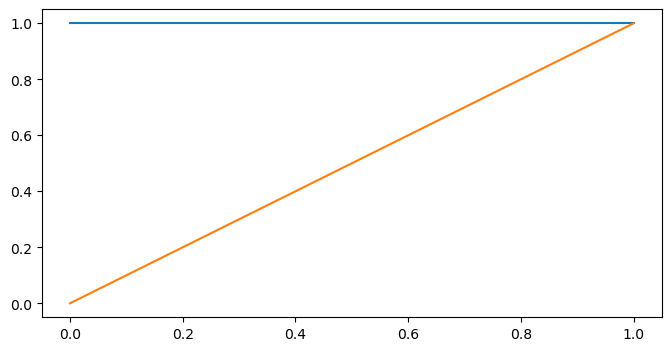

In [98]:
fig = plt.figure(figsize=(8,4))

for site in range(num_sites):
    plt.plot(times, [exp_val.real for exp_val in tebd_sim.results[site]])

plt.xlabel("Time $t$")
plt.ylabel("Expectation Values$")

In [99]:
for node_id in tebd_sim.state.nodes:
    local_tensor = tebd_sim.state.nodes[node_id].tensor
    print(local_tensor.shape)

(2, 2)
(2, 2, 2)
(2, 2, 2)
(2, 2, 2)
(2, 2, 2)
(2, 2, 2)
(2, 2, 2)
(2, 2, 2)
(2, 2, 2)
(2, 2)


In [100]:
print(tebd_sim.results.shape)

(2, 1001)
